# Data exploratory analysis

The goal of this notebook is to explore the data and identify potential interesting insights

In [1]:
import pandas as pd
import numpy as np

# Statistics + plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

## 1. Import data

In [2]:
# Open categories.cvs
categories = pd.read_csv('../project-4/data/clean-data/categories-post.csv')

# Explore data
categories.head()

,Unnamed: 0,Category,Sub-category,Keyword,Search Vol (min),Search Vol (max),Number of templates
0,0,Video,Facebook Video,Facebook Video template,23.076923,230.769231,145
1,1,Video,Social Feed Video Ad,Social Feed Video Ad template,2.307692,23.076923,159
2,2,Video,Pinterest Video Pin,Pinterest Video Pin template,2.307692,23.076923,21
3,3,Video,In-Stream Video Ad,In-Stream Video Ad template,2.307692,23.076923,149
4,4,Video,Youtube Intro,Youtube Intro template,230.769231,2307.692308,126


In [3]:
# Open .csv with Search trends and store them into a list of dics

csv_names = []
trends = {}

# Replace ' ' for '-'
for sub in categories['Sub-category']:
    csv_names.append(sub.replace(' ', '-').lower())
    
# Import .csv files
for name, sub in zip(csv_names, categories['Sub-category']):
    trends.update({sub: pd.read_csv(f'../project-4/data/clean-data/{name}.csv')})
    trends[sub].drop('Unnamed: 0', axis=1, inplace=True)
    
# Explore the data
trends['Instagram Ad']

,Date,Trend,isPartial,Category,Sub-category,Keyword,Search Vol (min),Search Vol (max),Number of templates,Search Vol (avge),Search Vol
0,2015-07-12,0,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1269,0.000000
1,2015-07-19,0,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1269,0.000000
2,2015-07-26,0,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1269,0.000000
3,2015-08-02,0,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1269,0.000000
4,2015-08-09,0,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1269,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
256,2020-06-07,20,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1269,461.538462
257,2020-06-14,20,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1269,461.538462
258,2020-06-21,31,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1269,715.384615
259,2020-06-28,42,False,Ads,Instagram Ad,Instagram Ad template,230.769231,2307.692308,111,1269,969.230769


## 2. Merging tables for the analysis

In [4]:
for sub in trends:
    try:
        trends[sub]['Date'] = pd.to_datetime(trends[sub]['Date'])
    except:
        pass

## 3. Basic plotting

### 3.1 Search volume evolution

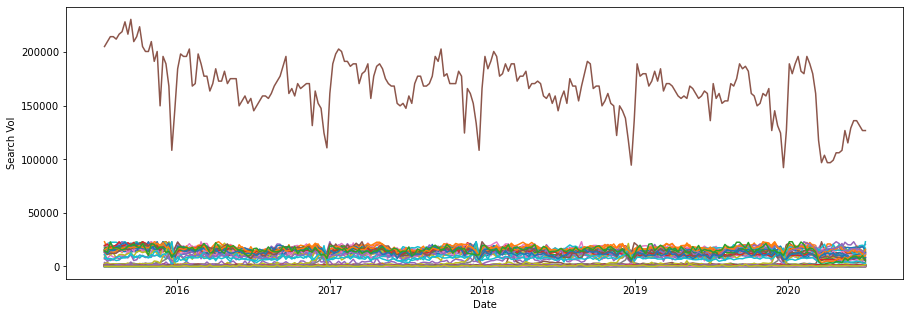

In [5]:
# Volume of searchs
plt.figure(figsize=(15,5))

for sub in trends:
    try:
    # Create a graph with the volume of searches
        ax = sns.lineplot(data=trends[sub], 
                          x='Date', 
                          y='Search Vol')
    except:
        pass

'Resume' sub-categorie has much more search vol than the rest. For the sake of the analysis, could be interesting to add some sub-categories.

In [6]:
# Same plot with subcategories with less than 10.000 monthly searches on average
trends_gp = {'Under 1k': pd.DataFrame(columns=['Date', 'Search Vol']),
             'Under 10k': pd.DataFrame(columns=['Date', 'Search Vol']),
             'Under 100k': pd.DataFrame(columns=['Date', 'Search Vol'])}

# Aggregate DataFrames by groups depending on Search Vol.
for sub in trends:
    try:
        # Subcategories with an avge of less than 1k monthly seaches
        if (trends[sub]['Search Vol'].mean() < 1000):
            trends_gp['Under 1k'] = pd.concat([trends_gp['Under 1k'], trends[sub]])
        
        # Subcategories with an avge of less than 10k monthly seaches
        elif (trends[sub]['Search Vol'].mean() < 10000):
            trends_gp['Under 10k'] = pd.concat([trends_gp['Under 10k'], trends[sub]])
    
        # Subcategories with an avge of less than 100k monthly seaches
        elif ((trends[sub]['Search Vol'].mean() < 100000) & (trends[sub]['Search Vol'].mean() > 10000)):
            trends_gp['Under 100k'] = pd.concat([trends_gp['Under 100k'], trends[sub]])
            
        # The rest will be analysed individually
        else:
            trends_gp[sub] = trends[sub]

    except:
        pass
    
# Grouping by day and summing 'Seatch Vol.'
trends_gp['Under 1k'] = trends_gp['Under 1k'].groupby('Date', as_index=False).agg('sum')
trends_gp['Under 10k'] = trends_gp['Under 10k'].groupby('Date', as_index=False).agg('sum')
trends_gp['Under 100k'] = trends_gp['Under 100k'].groupby('Date', as_index=False).agg('sum')

In [7]:
# Checking the results
trends_gp['Under 100k'].head()

,Date,Search Vol,Trend,Search Vol (min),Search Vol (max),Number of templates,Search Vol (avge)
0,2015-07-12,349384.615385,1514.0,55384.615385,553846.153846,30767.0,304608.0
1,2015-07-19,369230.769231,1600.0,55384.615385,553846.153846,30767.0,304608.0
2,2015-07-26,371076.923077,1608.0,55384.615385,553846.153846,30767.0,304608.0
3,2015-08-02,368307.692308,1596.0,55384.615385,553846.153846,30767.0,304608.0
4,2015-08-09,376384.615385,1631.0,55384.615385,553846.153846,30767.0,304608.0


Now we have a dictionary with a DataFrame that aggregates the subcategories with less than 1k monthly searches as 'Under 1k', less than 10k monthly searches as 'Under 10k', a DataFrame that aggregates the subcategories with less that 100k monthly searches as 'Under 100k' and individual DataFrames for those subcategories with more than 100k monthly searches.

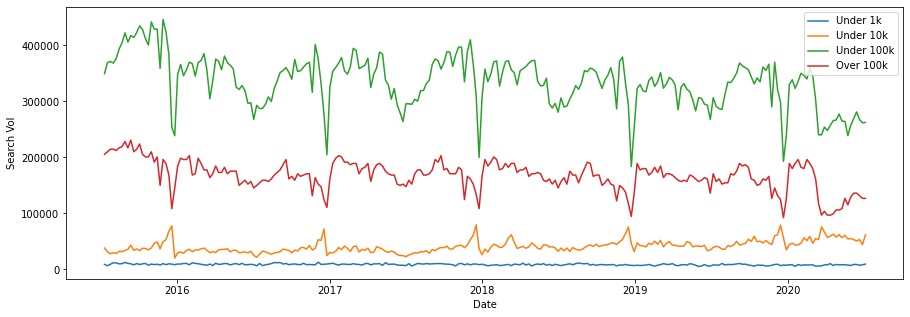

In [8]:
# Plot 
plt.figure(figsize=(15,5))

new_labels = trends_gp.keys()

for sub in trends_gp:
    # Create a graph with the volume of searches
    ax = sns.lineplot(data=trends_gp[sub], 
                  x='Date', 
                  y='Search Vol')

# Add legend    
plt.legend(labels=['Under 1k', 'Under 10k', 'Under 100k', 'Over 100k']);

It would be useful to list the subcategories in each category.

### 3.2 Search volume aggregated trend

In [9]:
# Combine all searches and find the trend. 
# We will be able to compare each sub_category with the overall trend
# Statistical analysis

In [10]:
trends_gp['Total'] = pd.DataFrame(columns=['Date', 'Search Vol'])

# Concat all DataFrames into one
for sub in trends:
    trends_gp['Total'] = pd.concat([trends_gp['Total'], trends[sub]])

trends_gp['Total'] = trends_gp['Total'].groupby('Date', as_index=False).agg('sum')

#### Calculate the fitted line

In [11]:
# Create a constant
trends_gp['Total'] = sm.add_constant(trends_gp['Total'], has_constant='add')
trends_gp['Total'] = trends_gp['Total'].assign(t=range(1, len(trends_gp['Total']) + 1))
# sub_dic_gp['Total'] = sub_dic_gp['Total'].assign(t2=range(1, (len(sub_dic_gp['Total']) + 1)**2))

In [12]:
# Run OLS
X = trends_gp['Total'][["const", "t"]]
y = trends_gp['Total']["Search Vol"]

lin_reg = sm.OLS(y, X)
results_total = lin_reg.fit()

results_total.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Search Vol   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     64.97
Date:                Sun, 12 Jul 2020   Prob (F-statistic):           2.81e-14
Time:                        16:48:36   Log-Likelihood:                -3240.5
No. Observations:                 261   AIC:                             6485.
Df Residuals:                     259   BIC:                             6492.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        6.05e+05   7438.099     81.340      0.000     5.9e+05     6.2e+05
t           -396.7390     49.219     -8.061      0.000    -493.660    -299.818
==============================================================================
Omnibus:                       28.680   Durbin-Watson:                   0.656
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.424
Skew:                          -0.801   Prob(JB):                     2.03e-08
Kurtosis:                       3.831   Cond. No.                         303.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

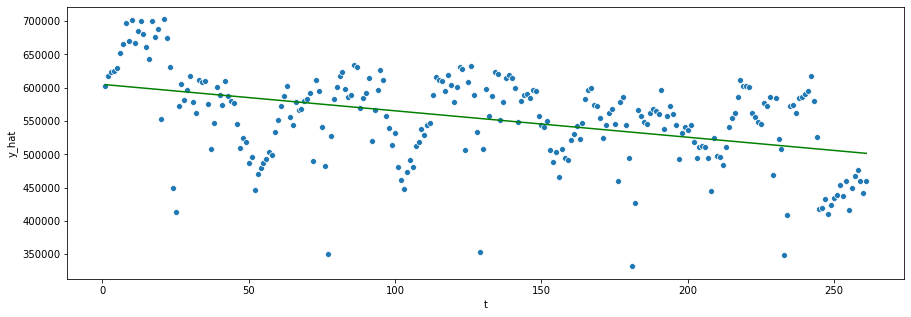

In [13]:
trends_gp['Total'] = trends_gp['Total'].assign(y_hat=results_total.predict(X))

plt.figure(figsize=(15,5))
    
sns.scatterplot(data=trends_gp['Total'], 
                x='t', 
                y='Search Vol');

sns.lineplot(data=trends_gp['Total'],
             x='t',
             y="y_hat",
             color="green");

### 3.3 Search Volume vs. Number of Templates

Is there a correlation between the Search Vol for the Keywords assigned to the Sub-category and the number of templates that Canva is offering? Is it statistically significant?

In [14]:
# Open categories.cvs
trends_all = pd.read_csv('../project-4/data/clean-data/trends-all.csv')

# Explore data

trends_all.drop('Unnamed: 0', axis=1, inplace=True)
trends_all.head()

,Date,Trend,Category,Sub-category,Keyword,Search Vol (min),Search Vol (max),Number of templates,Search Vol (avge),Search Vol,isPartial,index
0,2015-07-12,21,Video,Facebook Video,Facebook Video template,23.076923,230.769231,145,126,48.461538,False,NaN
1,2015-07-19,31,Video,Facebook Video,Facebook Video template,23.076923,230.769231,145,126,71.538462,False,NaN
2,2015-07-26,20,Video,Facebook Video,Facebook Video template,23.076923,230.769231,145,126,46.153846,False,NaN
3,2015-08-02,41,Video,Facebook Video,Facebook Video template,23.076923,230.769231,145,126,94.615385,False,NaN
4,2015-08-09,27,Video,Facebook Video,Facebook Video template,23.076923,230.769231,145,126,62.307692,False,NaN


In [15]:
# Group by sub-category
trends_all_gp = trends_all.groupby('Sub-category').agg('mean').reset_index(drop=False)
trends_all_gp.head()

,Sub-category,Trend,Search Vol (min),Search Vol (max),Number of templates,Search Vol (avge),Search Vol,isPartial,index
0,A4 Document,18.984674,2.307692,23.076923,3100.0,12.0,4.381079,0.003831,NaN
1,Announcement,54.394636,230.769231,2307.692308,1122.0,1269.0,1255.260831,0.003831,NaN
2,Birthday Card,64.172414,2307.692308,23076.923077,679.0,12692.0,14809.018568,0.003831,NaN
3,Birthday Invitation,66.563218,2307.692308,23076.923077,957.0,12692.0,15360.742706,0.003831,NaN
4,Bookmark,50.452107,2307.692308,23076.923077,223.0,12692.0,11642.793988,0.003831,NaN


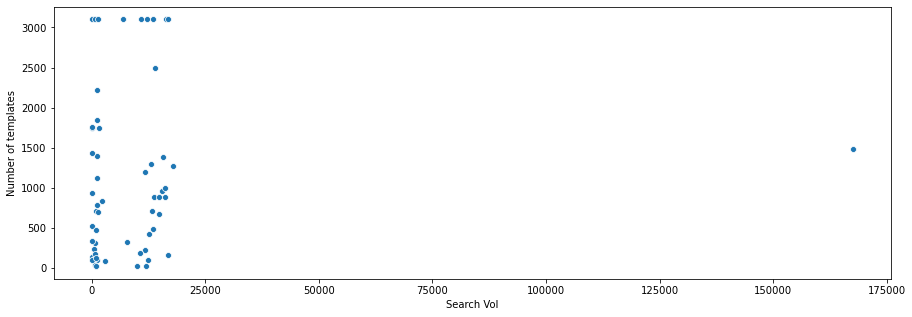

In [16]:
# Scatter plot to infere if it makes sense to calculate the fitted line
plt.figure(figsize=(15,5))

sns.scatterplot(data=trends_all_gp, 
                x=trends_all_gp['Search Vol'], 
                y=trends_all_gp['Number of templates']);

In [17]:
# See if there is a correlation between the two variables
trends_all_gp = sm.add_constant(trends_all_gp, has_constant='add')

# Run OLS
lin_reg = sm.OLS(trends_all_gp["Number of templates"],
                 trends_all_gp[["Search Vol"]])

result = lin_reg.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     Number of templates   R-squared (uncentered):                   0.121
Model:                             OLS   Adj. R-squared (uncentered):              0.106
Method:                  Least Squares   F-statistic:                              7.985
Date:                 Sun, 12 Jul 2020   Prob (F-statistic):                     0.00646
Time:                         16:48:37   Log-Likelihood:                         -511.74
No. Observations:                   59   AIC:                                      1025.
Df Residuals:                       58   BIC:                                      1028.
Df Model:                            1                                                  
Covariance Type:             nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Search Vol     0.0222      0.008      2.826      0.006       0.006       0.038
==============================================================================
Omnibus:                        2.818   Durbin-Watson:                   1.352
Prob(Omnibus):                  0.244   Jarque-Bera (JB):                2.171
Skew:                           0.463   Prob(JB):                        0.338
Kurtosis:                       3.160   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

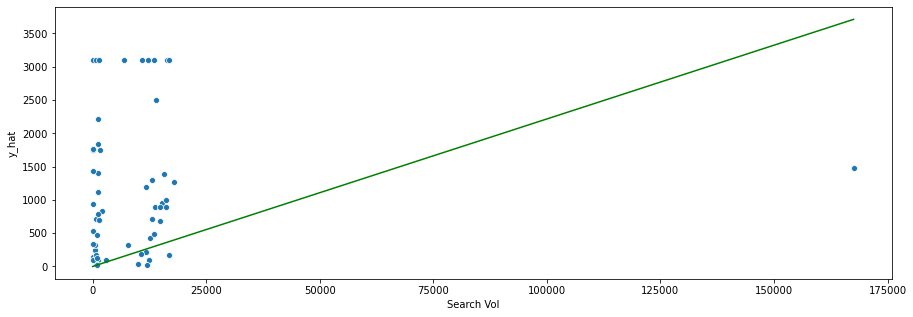

In [18]:
trends_all_gp = trends_all_gp.assign(y_hat=result.predict(trends_all_gp[["Search Vol"]]))

plt.figure(figsize=(15,5))
    
sns.scatterplot(data=trends_all_gp, 
                x='Search Vol', 
                y='Number of templates');

sns.lineplot(data=trends_all_gp,
             x='Search Vol',
             y="y_hat",
             color="g");

That model is too affected by the 'Resume' outlier. I will try do the same process without the 'Document' category

In [19]:
trends_all_gp = trends_all_gp[trends_all_gp['Sub-category'] != 'Resume']

In [20]:
# See if there is a correlation between the two variables
trends_all_gp = sm.add_constant(trends_all_gp, has_constant='add')

# Run OLS
lin_reg = sm.OLS(trends_all_gp["Number of templates"],
                 trends_all_gp[["Search Vol"]])

result = lin_reg.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     Number of templates   R-squared (uncentered):                   0.354
Model:                             OLS   Adj. R-squared (uncentered):              0.342
Method:                  Least Squares   F-statistic:                              31.21
Date:                 Sun, 12 Jul 2020   Prob (F-statistic):                    6.77e-07
Time:                         16:48:37   Log-Likelihood:                         -494.16
No. Observations:                   58   AIC:                                      990.3
Df Residuals:                       57   BIC:                                      992.4
Df Model:                            1                                                  
Covariance Type:             nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Search Vol     0.0964      0.017      5.587      0.000       0.062       0.131
==============================================================================
Omnibus:                        4.113   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.128   Jarque-Bera (JB):                3.959
Skew:                           0.592   Prob(JB):                        0.138
Kurtosis:                       2.512   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

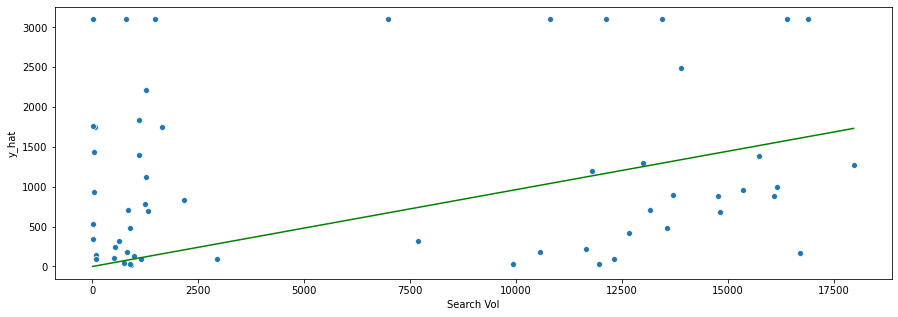

In [21]:
trends_all_gp = trends_all_gp.assign(y_hat=result.predict(trends_all_gp[["Search Vol"]]))

plt.figure(figsize=(15,5))
    
sns.scatterplot(data=trends_all_gp, 
                x='Search Vol', 
                y='Number of templates');

sns.lineplot(data=trends_all_gp,
             x='Search Vol',
             y="y_hat",
             color="g");

In [22]:
# Export a list of the Sub-categories to prioritise
y_hat = 0.0964 * trends_all_gp['Search Vol']
y_hat
trends_all_gp.head()

,const,const,Sub-category,Trend,Search Vol (min),Search Vol (max),Number of templates,Search Vol (avge),Search Vol,isPartial,index,y_hat
0,1.0,1.0,A4 Document,18.984674,2.307692,23.076923,3100.0,12.0,4.381079,0.003831,NaN,0.422270
1,1.0,1.0,Announcement,54.394636,230.769231,2307.692308,1122.0,1269.0,1255.260831,0.003831,NaN,120.988244
2,1.0,1.0,Birthday Card,64.172414,2307.692308,23076.923077,679.0,12692.0,14809.018568,0.003831,NaN,1427.366413
3,1.0,1.0,Birthday Invitation,66.563218,2307.692308,23076.923077,957.0,12692.0,15360.742706,0.003831,NaN,1480.544313
4,1.0,1.0,Bookmark,50.452107,2307.692308,23076.923077,223.0,12692.0,11642.793988,0.003831,NaN,1122.190037


In [23]:
priorities = pd.DataFrame(trends_all_gp[trends_all_gp['y_hat'] > trends_all_gp['Number of templates']]['Sub-category'])
priorities

# Add the search vol and sort
priorities = priorities.merge(trends_all_gp[['Sub-category', 'Search Vol', 'y_hat', 'Number of templates']], how='left', on='Sub-category')

# Add a column with the templates 'to create'
priorities['Templates to create'] = priorities['y_hat'] - priorities['Number of templates']

# Rename column
priorities = priorities.rename(columns={'y_hat': 'Recommended templates'})

# Round numbers
priorities['Search Vol'] = round(priorities['Search Vol'], 0)
priorities['Recommended templates'] = round(priorities['Recommended templates'], 0)
priorities['Templates to create'] = round(priorities['Templates to create'], 0)

# Sort descending order by Search Vol
priotities = priorities.sort_values(by='Search Vol', ascending=False).reset_index(drop=True)
priotities.head()

,Sub-category,Search Vol,Recommended templates,Number of templates,Templates to create
0,Report,17969.0,1732.0,1273.0,459.0
1,Invoice,16715.0,1611.0,167.0,1444.0
2,Presentation,16153.0,1557.0,1000.0,557.0
3,Letter,16085.0,1550.0,886.0,664.0
4,Logo,15741.0,1517.0,1383.0,134.0


In [24]:
len(priorities)

23

In [25]:
priorities.to_csv('../project-4/data/clean-data/priorities.csv', sep=',')

I would recommend to look into the 23 sub-categories that are included in the 'priorities' file since are the ones that our model says that could improve if we add more templates. The list is sorted by the search volumen and it has a column 'Templates to create' that tells the number of templates that are recommended. 

The model is only able to explain 35% of the variance of the dependent variable (Number of templates). So, it would be necessary to understand the rest of the factors that influence on the relation in order adjust the recommendations. 